# Mean profile based moa prediction

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [48]:
import pyarrow
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import ConfusionMatrixDisplay

# Data

In [65]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    data_dir = data_root / "scip"
    paths = data_dir.rglob("features.parquet")
    labels_path = data_dir.parent / "labels.parquet"
    moa_path = data_root / "BBBC021_v1_moa.csv"

In [66]:
%%time
paths = list(paths)[:3]
df = pandas.concat([pq.read_table(p).to_pandas() for p in paths])
df = df.drop(columns=df.filter(regex='meta_image_.*').columns.tolist() + ["meta_replicate", "meta_imagenumber", "meta_tablenumber"])

CPU times: user 5.6 s, sys: 7.78 s, total: 13.4 s
Wall time: 20.3 s


In [67]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [68]:
df.shape

(914258, 677)

In [69]:
df = df[~df.isna().any(axis=1)]

In [70]:
labels = pq.read_table(labels_path).to_pandas()

In [71]:
df = df.merge(labels, left_on="meta_filename", right_on="meta_image_filename_dapi", suffixes=("_", ""), how="inner")

In [72]:
df["meta_moa"].unique().shape

(11,)

# Removing interplate variation

In [73]:
qq_dmso = df[df["meta_moa"] == "DMSO"].groupby("meta_image_metadata_plate_dapi")[df.filter(regex="feat").columns].quantile((0.01, 0.99))

In [74]:
dfs = []
for idx, gdf in df.groupby("meta_image_metadata_plate_dapi"):
    print(idx)
    df_scaled = (gdf.filter(regex="feat") - qq_dmso.loc[idx, 0.01]) / (qq_dmso.loc[idx, 0.99] - qq_dmso.loc[idx, 0.01])
    df_scaled = pandas.concat([df_scaled, gdf.filter(regex="meta")], axis=1)
    
    dfs.append(df_scaled)

Week2_24121
Week2_24141
Week2_24161
Week2_24361
Week2_24381
Week2_24401
Week3_25421
Week3_25441
Week3_25461
Week3_25681
Week3_25701
Week3_25721
Week4_27481
Week4_27521
Week4_27542
Week4_27801
Week4_27821
Week4_27861
Week5_28901
Week5_28961
Week5_29301
Week5_29321
Week5_29341


In [75]:
df = pandas.concat(dfs)
del dfs

In [76]:
df.columns[df.isna().all()]

Index(['feat_euler_number_combined', 'feat_euler_number_actin',
       'feat_euler_number_tubulin'],
      dtype='object')

In [77]:
nancols = df.columns[df.isna().any()]
nancols

Index(['feat_euler_number_combined', 'feat_euler_number_DAPI',
       'feat_euler_number_actin', 'feat_euler_number_tubulin'],
      dtype='object')

In [78]:
df = df.drop(columns=nancols)

# Converting per-cell profiles to treatment profiles

In [79]:
fa = FactorAnalysis(random_state=0, n_components=100)

In [80]:
%%time
fa.fit(df[df["meta_compound"] == "DMSO"].filter(regex="feat").sample(n=50000))

CPU times: user 1min 16s, sys: 812 ms, total: 1min 17s
Wall time: 1min 17s


FactorAnalysis(n_components=100)

In [81]:
%%time
dfs = []
for idx, gdf in df[df["meta_moa"] != "DMSO"].groupby(["meta_compound", "meta_concentration"]):
    tmp_df = pandas.Series(data=fa.transform(gdf.filter(regex="feat")).mean(axis=0))
    tmp_df.index = ["feat_"+str(c) for c in tmp_df.index]
    tmp_df["meta_compound"] = idx[0]
    tmp_df["meta_concentration"] = idx[1]
    dfs.append(tmp_df)
    
mu = pandas.DataFrame(dfs)

CPU times: user 1.24 s, sys: 101 ms, total: 1.34 s
Wall time: 1.35 s


In [35]:
del dfs

In [36]:
mu.shape

(103, 102)

In [37]:
moa = pandas.read_csv(moa_path).set_index(["compound", "concentration"])

In [38]:
treatment_profiles = mu.set_index(["meta_compound", "meta_concentration"])
treatment_profiles.index.names = ["compound", "concentration"]
treatment_profiles = treatment_profiles.merge(moa, left_index=True, right_index=True).reset_index()

# Exploration

In [ ]:
seaborn.countplot(data=treatment_profiles, y="moa")

In [ ]:
seaborn.countplot(data=treatment_profiles, y="compound")

## dimdred

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [89]:
dimred = PCA().fit_transform(treatment_profiles.filter(regex="feat"))

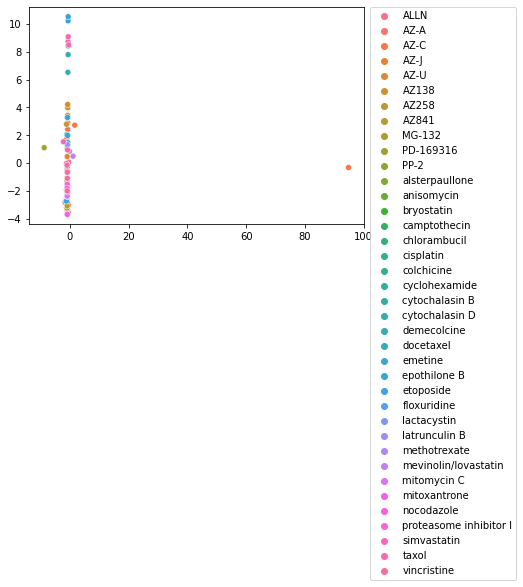

In [90]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

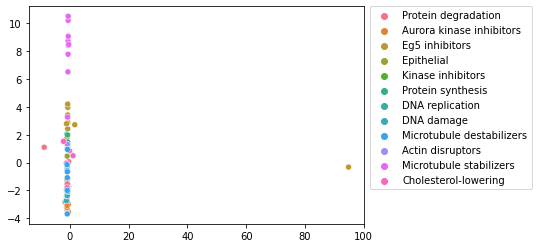

In [91]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [92]:
from umap import UMAP

In [93]:
dimred = UMAP(metric="cosine", min_dist=0.5, n_neighbors=8, random_state=0).fit_transform(treatment_profiles.filter(regex="feat"))

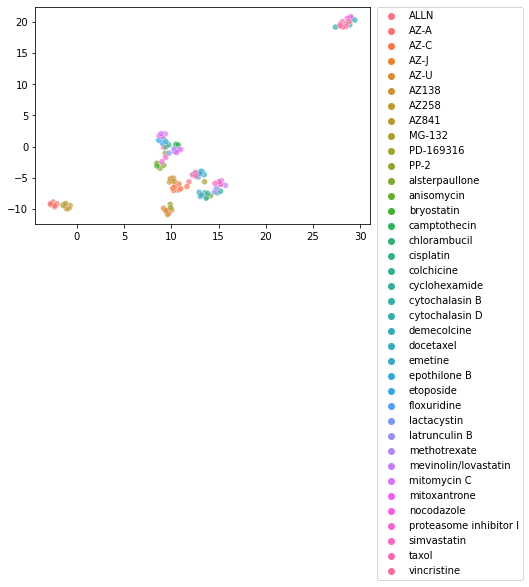

In [94]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

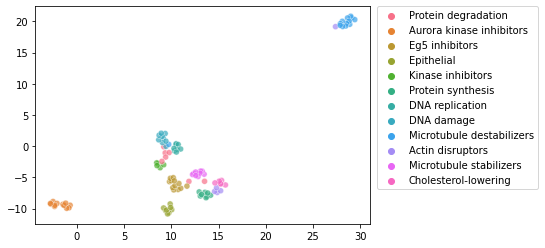

In [95]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [107]:
df.shape

(498574, 682)

In [119]:
dropcols = df.filter(regex="meta").columns.tolist()
df[set(df.columns) - set(dropcols)]

,feat_combined_bgcorr_edge_kurtosis_DAPI,feat_moments-1-3_DAPI,feat_moments_central-0-1_actin,feat_perimeter_tubulin,feat_combined_bgcorr_sum_actin,feat_bgcorr_edge_max_tubulin,feat_moments_central-3-3_actin,feat_glcm_std_correlation_3_tubulin,feat_combined_glcm_std_correlation_3_actin,feat_median_DAPI,...,feat_combined_bgcorr_min_tubulin,feat_glcm_std_ASM_5_tubulin,feat_moments_central-2-0_actin,feat_mean_DAPI,feat_glcm_std_correlation_5_DAPI,feat_edge_upper_quartile_actin,feat_median_tubulin,feat_combined_glcm_std_contrast_5_tubulin,feat_combined_edge_kurtosis_DAPI,feat_combined_bgcorr_std_tubulin
261293,0.322274,0.138936,-0.721102,0.605730,0.372885,0.245597,0.464158,0.189431,0.152710,0.186722,...,0.620000,0.049059,0.037530,0.160883,0.109198,0.368654,0.337999,0.224629,0.322274,0.195050
261294,0.341004,0.001018,0.514142,0.111159,0.037444,0.615099,0.478542,0.875638,0.123660,-0.008299,...,0.544000,0.128162,-0.001350,0.117070,0.039496,0.490150,0.862871,1.111312,0.341004,0.740195
261295,0.375444,0.166549,1.770582,0.643978,0.455385,0.461324,0.507446,0.301795,0.036219,0.099585,...,0.264000,0.354514,0.069001,0.084056,0.057850,0.420724,0.030641,0.225330,0.375444,0.342674
261296,0.117000,0.674646,-0.047160,0.444213,0.514438,0.258872,0.466442,0.175357,0.225858,0.070539,...,0.352000,0.291963,0.138285,0.078643,0.283807,0.242819,0.283620,0.320887,0.117000,0.301019
261297,0.123261,0.206152,0.424940,0.594081,0.494651,0.497832,0.458677,0.019710,0.019761,-0.012448,...,0.620000,0.119586,0.117213,-0.004117,0.438978,0.290549,0.494042,0.000061,0.123261,0.419175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261288,1.508410,0.372609,0.688527,0.804990,0.724493,0.508836,0.351435,0.153976,0.056887,0.306993,...,-0.014759,0.559293,0.342960,0.297814,0.033382,0.191181,0.152054,0.075788,1.508410,0.274570
261289,0.202148,0.143063,0.600313,0.396704,0.280491,0.160845,0.488678,0.259005,0.118050,0.095932,...,0.432922,0.184750,0.070953,0.092415,0.198046,0.417728,0.207883,0.156970,0.202148,0.217407
261290,0.088863,0.092951,0.572713,0.354206,0.338619,0.201309,0.481076,0.068464,0.033589,0.126084,...,0.063954,0.034838,0.071484,0.111126,0.128928,0.127107,0.058263,0.071979,0.088863,0.240185
261291,0.027232,0.185506,0.605247,0.493806,0.691514,0.397560,0.485632,0.154103,0.084439,0.528104,...,0.000000,0.054398,0.106307,0.496448,0.295792,0.145414,0.169920,0.449199,0.027232,0.682201


# Prediction

In [39]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [40]:
%%time
results = cross_validate(
    cv=LeaveOneGroupOut(),
    X=treatment_profiles.filter(regex="feat"),
    y=treatment_profiles["moa"],
    groups=treatment_profiles["compound"],
    estimator=make_pipeline(
        KNeighborsClassifier(n_neighbors=1, metric="cosine"),
    ),
    return_train_score=True,
    return_estimator=True,
    scoring=("accuracy", "balanced_accuracy", "f1_macro", "precision_macro")
)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/gent/420/vsc

CPU times: user 625 ms, sys: 10.5 ms, total: 636 ms
Wall time: 639 ms


/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [41]:
results["train_accuracy"].mean(), results["train_accuracy"].std()

(1.0, 0.0)

In [42]:
results["test_accuracy"].mean(), results["test_accuracy"].std()

(0.843358395989975, 0.31918747070218345)

In [43]:
%%time
preds = []
true = []
for e, (_, test_index) in zip(
    results["estimator"], 
    LeaveOneGroupOut().split(treatment_profiles.filter(regex="feat"), treatment_profiles["moa"], treatment_profiles["compound"])
):
    pred = e.predict(treatment_profiles.filter(regex="feat").iloc[test_index])
    preds.extend(pred)
    true.extend(treatment_profiles["moa"].iloc[test_index])

CPU times: user 127 ms, sys: 873 µs, total: 127 ms
Wall time: 129 ms


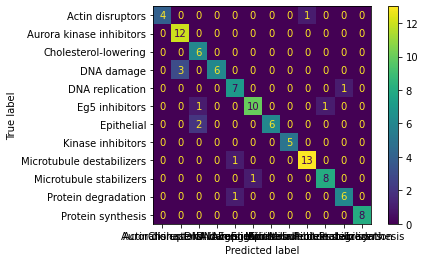

In [44]:
ConfusionMatrixDisplay.from_predictions(true, preds)

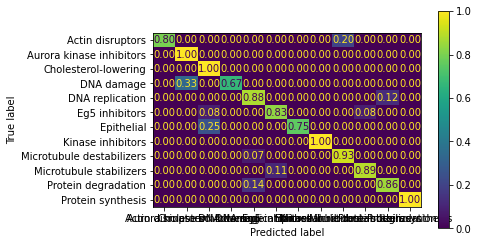

In [45]:
disp = ConfusionMatrixDisplay.from_predictions(true, preds, normalize='true', values_format=".2f")
disp.ax_.set_aspect(0.65)